# RSA

## Setup

In [1]:
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
from src import stats, plotting, temporal, decoding, rsa

pd.set_option('display.max_rows', None)

In [2]:
subj = 'subj010'
process = 'EEG_RSA'
eeg_metric = 'correlation'
regress_gaze = False
run_splithalf_reliability = True
run_fmri_rsa = False
run_feature_decoding = True
run_feature_rsa = True

top_path = '/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis'
data_dir = f'{top_path}/data'
figure_dir = f'{top_path}/reports/figures/{process}'

Path(figure_dir).mkdir(exist_ok=True, parents=True)
Path(f'{data_dir}/interim/{process}').mkdir(exist_ok=True, parents=True)

In [3]:
rois = ['EVC', 'MT', 'EBA',
        'LOC', 'FFA', 'PPA',
        'pSTS', 'face-pSTS', 'aSTS']
features = ['alexnet', 'moten', 'indoor',
                 'expanse', 'object_directedness', 'agent_distance',
                 'facingness', 'joint_action', 'communication', 
                 'valence', 'arousal']
annotated_features = ['indoor', 'expanse', 'object_directedness', 
                 'agent_distance', 'facingness', 'joint_action', 
                 'communication', 'valence', 'arousal']

In [4]:
df = pd.read_csv(f'{data_dir}/interim/PreprocessData/{subj}_reg-gaze-{regress_gaze}.csv.gz')
all_cols = set(df.columns.to_list())
other_cols = set(['trial', 'time', 'offset', 'offset_eyetrack_x', 'video_name',
              'gaze_x', 'gaze_y', 'pupil_size', 'target_x', 'target_y',
               'target_distance', 'offset_eyetrack_y', 'repetition', 'even'])
channels = list(all_cols - other_cols)
feature_df = pd.read_csv(f'{data_dir}/interim/FeatureRDMs/feature_annotations.csv')

## Reliability

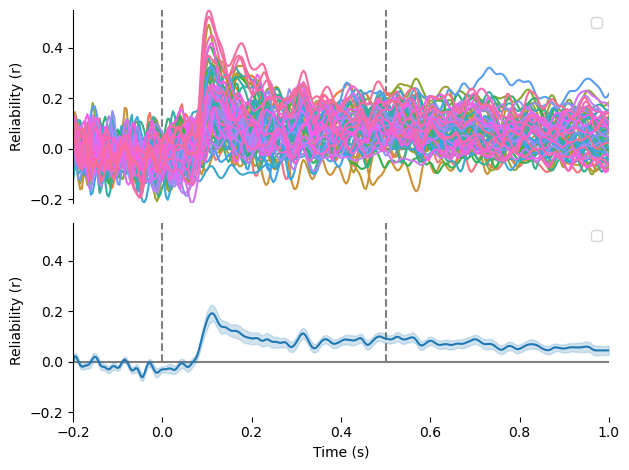

In [5]:
if run_splithalf_reliability:
    df_split = df.groupby(['time', 'video_name', 'even']).mean().reset_index()
    results = []
    time_groups = df_split.groupby('time')
    for time, time_df in time_groups:
        even = time_df[time_df.even].sort_values('video_name')
        odd = time_df[~time_df.even].sort_values('video_name')
        rs = stats.corr2d(even[channels].to_numpy(), odd[channels].to_numpy())
        results.append([time,] + list(rs))
    results = pd.DataFrame(results, columns=['time',] + channels)
    results = pd.melt(results, id_vars=['time'], value_vars=channels, var_name='channel', value_name='reliability')

    plotting.plot_splithalf_reliability(results, f'{figure_dir}/{subj}_reg-gaze-{regress_gaze}_reliability.png')

## RSA

### EEG - Feature RSA

/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis/src/temporal.py:44: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['video1', 'video2'], dtype='object')
  rolling_df = df.groupby(grouping).apply(lambda x: x.rolling(window=5, min_periods=2, step=2).mean())
/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis/src/plotting.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


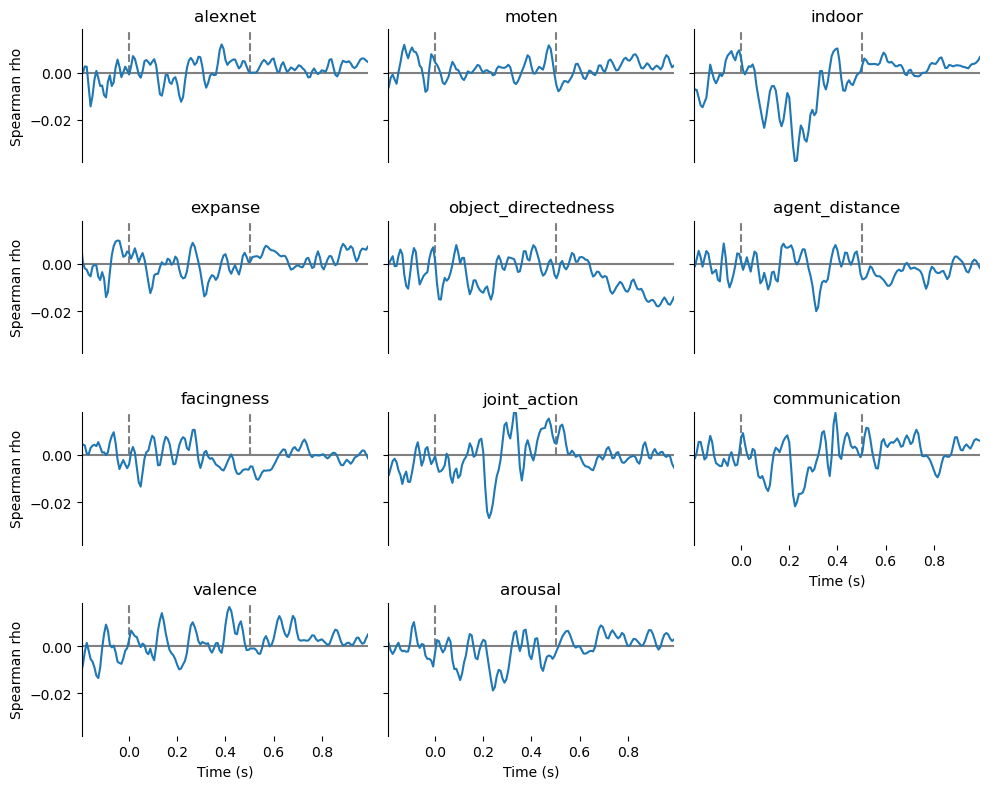

In [6]:
if eeg_metric == 'correlation':
    eeg_rdms = pd.read_csv(f'{data_dir}/interim/CorrelationDistance/{subj}_reg-gaze-{regress_gaze}.csv.gz')
else:
    eeg_rdms = pd.read_csv(f'{data_dir}/interim/PairwiseDecoding/{subj}_reg-gaze-{regress_gaze}.csv.gz')
eeg_rdms = temporal.smoothing(eeg_rdms)
feature_rdms = pd.read_csv(f'{data_dir}/interim/FeatureRDMs/feature_rdms.csv')

if run_feature_rsa:
    valid_videos = np.unique(np.concatenate([eeg_rdms.video1.to_numpy(),
                                            eeg_rdms.video2.to_numpy()]))
    filtered_feature_rdms = rsa.filter_pairs(feature_rdms, valid_videos)

    out_file = f'{data_dir}/interim/{process}/{subj}_feature_EEG-{eeg_metric}_reg-gaze-{regress_gaze}_rsa.csv'
    results = rsa.compute_eeg_feature_rsa(feature_rdms, eeg_rdms, features)
    results.to_csv(out_file, index=False)

    out_figure = f'{figure_dir}/{subj}_feature_EEG-{eeg_metric}_reg-gaze-{regress_gaze}_rsa.png'
    plotting.plot_eeg_feature_rsa(results, features, out_figure)

### EEG - fMRI RSA

In [7]:
def load_fMRI_RDMs(files):
    fmri_rdms = []
    for file in files:
        fr = pd.read_csv(file)
        fmri_subj_name = file.split('/')[-1].split('_')[0]
        fr['subj'] = fmri_subj_name
        fmri_rdms.append(fr)
    fmri_rdms = pd.concat(fmri_rdms)
    fmri_rdms = fmri_rdms.groupby(['roi', 'video1', 'video2']).mean(numeric_only=True).reset_index()
    fmri_rdms.sort_values(by=['roi', 'video1', 'video2'])
    return fmri_rdms

In [8]:
if run_fmri_rsa:
    for fMRI_metric in ['correlation', 'decoding']:
        files = glob(f'{fMRI_path}/*set-test*{fMRI_metric}-distance.csv')
        fmri_rdms = load_fMRI_RDMs(files)
        fmri_videos = np.unique(np.concatenate([fmri_rdms.video1.to_numpy(),
                                    fmri_rdms.video2.to_numpy()]))

        for EEG_metric in ['correlation', 'decoding']:
            if eeg_rdms[EEG_metric] is not None:
                filtered_eeg_rdms = rsa.filter_pairs(eeg_rdms[EEG_metric], fmri_videos)
                valid_videos = np.unique(np.concatenate([filtered_eeg_rdms.video1.to_numpy(),
                                                    filtered_eeg_rdms.video2.to_numpy()]))
                filtered_fmri_rdms = rsa.filter_pairs(fmri_rdms, valid_videos)

                out_file = f'{out_path}/{subj}_fMRI-{fMRI_metric}_EEG-{EEG_metric}_rsa.csv'
                results = rsa.compute_eeg_fmri_rsa(filtered_fmri_rdms, filtered_eeg_rdms, rois)
                results.to_csv(out_file, index=False)

                out_figure = f'{figure_path}/{subj}_fMRI-{fMRI_metric}_EEG-{EEG_metric}_rsa.png'
                plotting.plot_eeg_fmri_rsa(results, out_figure)


## Decoding

/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis/src/temporal.py:44: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['video_name'], dtype='object')
  rolling_df = df.groupby(grouping).apply(lambda x: x.rolling(window=5, min_periods=2, step=2).mean())
/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis/src/plotting.py:148: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


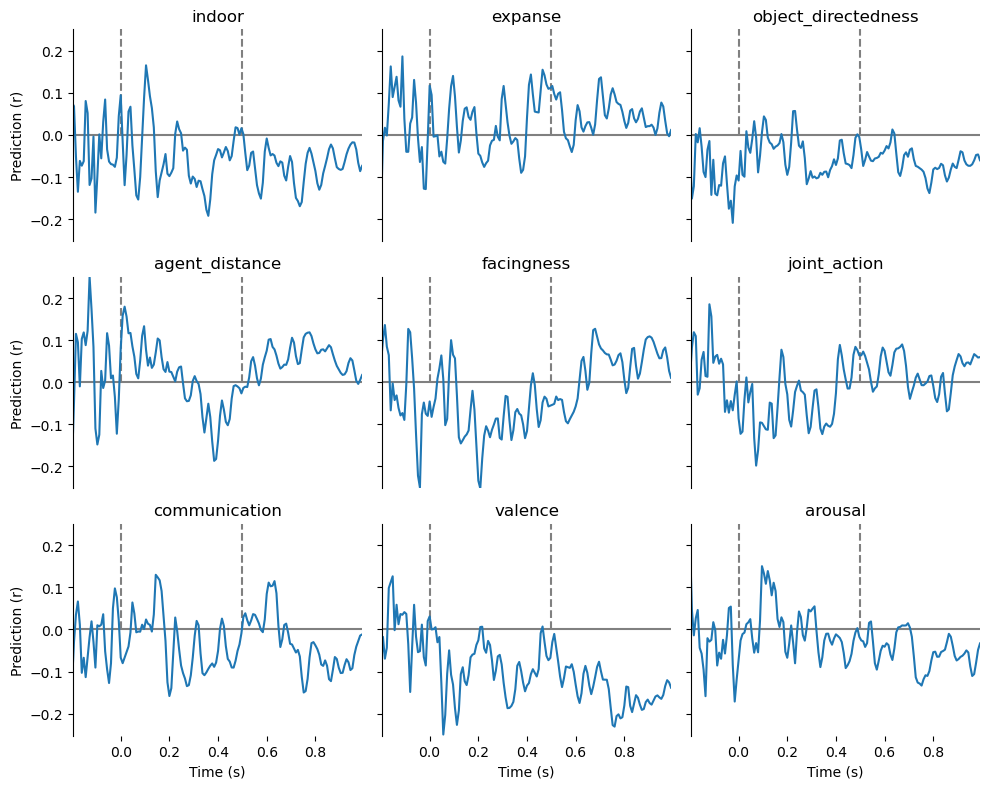

In [9]:
if run_feature_decoding: 
    videos = np.array(feature_df['video_name'])
    df_avg = df.groupby(['time', 'video_name']).mean(numeric_only=True).reset_index()
    cols_to_drop = set(df.columns.to_list()) - set(['time', 'video_name'] + channels)
    df_avg.drop(columns=cols_to_drop, inplace=True)
    df_avg.sort_values(['time', 'video_name'], inplace=True)
    df_avg = temporal.smoothing(df_avg, 'video_name')

    results = decoding.eeg_feature_decoding(df_avg, feature_df,
                                            annotated_features, channels)
    results.to_csv(f'{data_dir}/interim/{process}/{subj}_feature_EEG_reg-gaze-{regress_gaze}_decoding.csv', index=False)

    out_file = f'{figure_dir}/{subj}_feature_EEG_reg-gaze-{regress_gaze}_decoding.png'
    plotting.plot_eeg_feature_decoding(out_file, results, annotated_features)